In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns
import os
import torch
import json
import sys

from pymatgen.core.structure         import Structure
from pymatgen.symmetry.bandstructure import HighSymmKpath

from libraries.model   import Helmholtz_free_energy_function, make_predictions, GCNN, compute_coefficients, compute_Fv
from libraries.dataset import load_atomic_masses, include_temperatures, create_predictions_dataset, standardize_dataset_from_keys

sys.path.append('../../UPC')
import MP.MP_library       as MPL

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

In [2]:
model_folder    = 'model'  # Pre-trained model and dataset parameters
output_folder   = 'output'  # Output files and figures
input_folder    = 'input'  # General files (e.g., atomic masses information)

# Whether to plot the harmonic extrapolations of Fv (very time-consuming) or not
plot_extrapolations = False

# Defining the range of temperatures
Ti = 200
Tf = 700
dT = 10
temperatures = np.arange(Ti, Tf+dT, dT)  # Temperatures for prediction of free-energies

# Loading dictionary of atomic masses
atomic_masses = load_atomic_masses(f'{input_folder}/atomic_masses.dat')

In [3]:
# Load the data from the JSON file
with open(f'{model_folder}/standardized_parameters.json', 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert NumPy arrays back to PyTorch tensors
standardized_parameters = {}
for key, value in numpy_dict.items():
    try:
        standardized_parameters[key] = torch.tensor(value)
    except:
        standardized_parameters[key] = value

# Load reference dataset for uncertainty estimation
reference_dataset = torch.load(f'{model_folder}/dataset_std.pt', weights_only=False)[:100]

In [4]:
def pred_ML_Fv(path_to_POSCAR, temperatures, standardized_parameters, model_folder, device):
    # Create dataset for predictions
    dataset = create_predictions_dataset(path_to_POSCAR, path_to_material=True, path_to_polymorph=True)
    labels = [graph.label for graph in dataset]

    # Standardize properties
    std_dataset = standardize_dataset_from_keys(dataset, standardized_parameters)

    # Load Graph Neural Network model (making room for temperature as node attribute) to device
    # Dropout for initializing the model, not used at all while predicting
    model = GCNN(features_channels=dataset[0].num_node_features+1,
                 pdropout=0).to(device)

    # Free-up CUDA
    del dataset

    # Load and evaluate Graph Neural Network model
    model.load_state_dict(torch.load(f'{model_folder}/model.pt', map_location=torch.device(device)))
    model.eval()

    # Include temperatures
    std_dataset_w_temp = include_temperatures(std_dataset, temperatures, standardized_parameters)

    # Free-up CUDA
    del std_dataset

    # Compute predictions and corresponding uncertainties
    shot_predictions, shot_uncertainties = make_predictions(reference_dataset, std_dataset_w_temp, model, standardized_parameters)

    # Free-up CUDA
    del std_dataset_w_temp

    # Computing the coefficients and uncertainties from fitting
    coefficients = compute_coefficients(temperatures, shot_predictions)
    
    # Compute Fv
    Fv_pred = compute_Fv(temperatures, coefficients)[0]
    return  Fv_pred, shot_uncertainties

def pred_DFT_Fv(path_to_PHONON, temperatures):
    # Loading number of atoms
    _, _, concentration, _ = MPL.information_from_VASPfile(path_to_PHONON, file='POSCAR')
    n_atoms = np.sum(concentration)
    
    # Reading supercell information
    dim_info = MPL.read_phonopyconf(path_to_PHONON)
    
    # Write mesh.conf file (needed for phonopy)
    MPL.write_meshconf(path_to_PHONON, material, dim_info, Ti, Tf, dT)
    
    # Getting thermal properties with phonopy (ignoring output)
    previous_dir = os.getcwd()
    os.chdir(path_to_PHONON)
    os.system('phonopy -t mesh.conf > /dev/null')
    os.chdir(previous_dir)
    
    # Read generated thermal properties (kJ/mol)
    _, Fv_PHONON = MPL.read_thermalpropertyyaml(len(temperatures), path_to_PHONON, thermalproperty='free_energy')
    
    # Pass kJ / molmp-1009220 to meV / atom
    conversion_factor = 1.6 * 6.022 * 0.01 * n_atoms
    Fv_PHONON        /= conversion_factor
    return Fv_PHONON

In [5]:
colors = ['b', 'r', 'g', 'k']

materials = {
    'CO': ['P2_12_12_1', 'R3c'],
    'MgTe': ['F-43m', 'P6_3mc'],
    'SeN': ['C2-c', 'P2_1-c'],
    'SrC2': ['C2-c', 'I4-mmm'],
    'WCl6': ['P-3m1', 'R-3'],
    'WN2': ['P3_121', 'Pna2_1'],
    'WSe2': ['P6_3-mmc', 'P-6m2'],
    'ZnCl2': ['P2_1-c', 'P4_2-nmc'],
    'ZnTe': ['F-43m', 'P6_3mc'],
    'ZrSeO': ['P2_13', 'P4-nmm']
}

CO


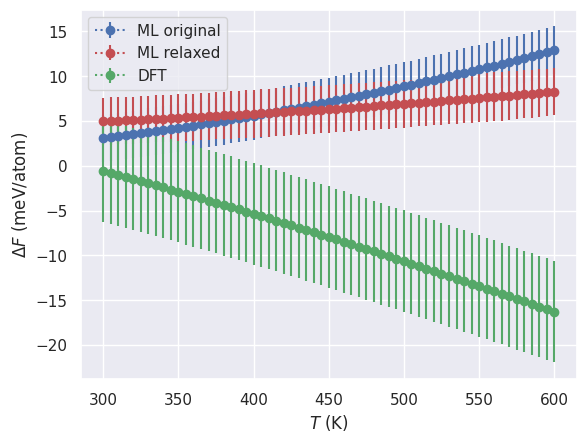

MgTe


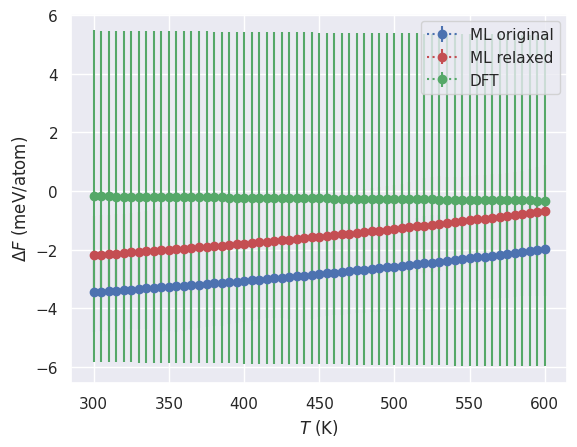

SeN


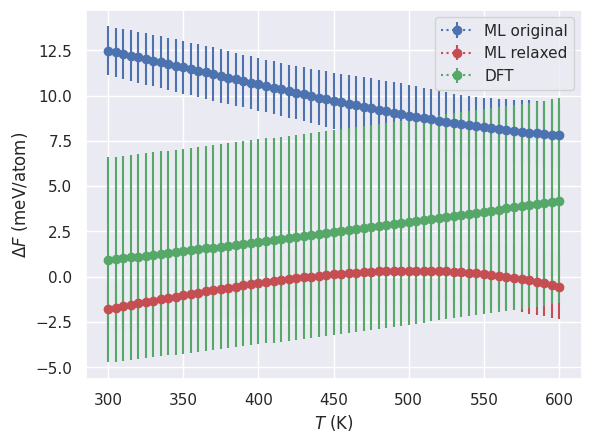

SrC2


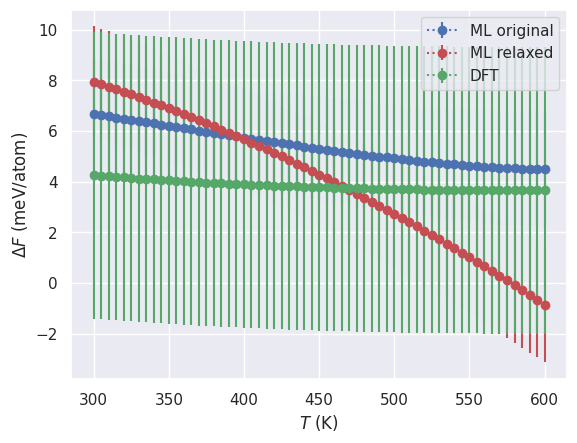

WCl6


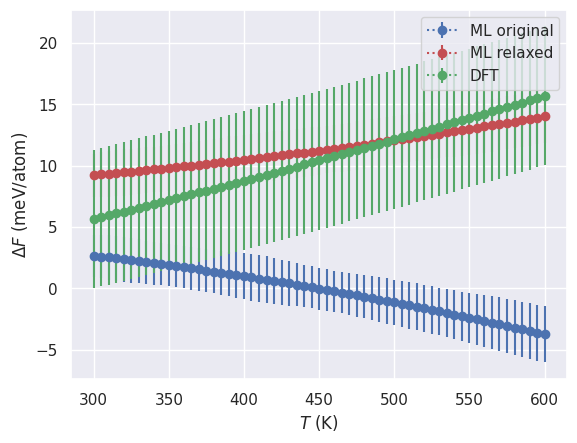

WN2


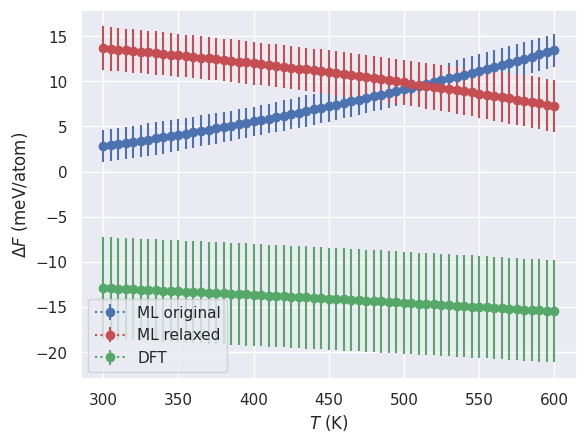

WSe2


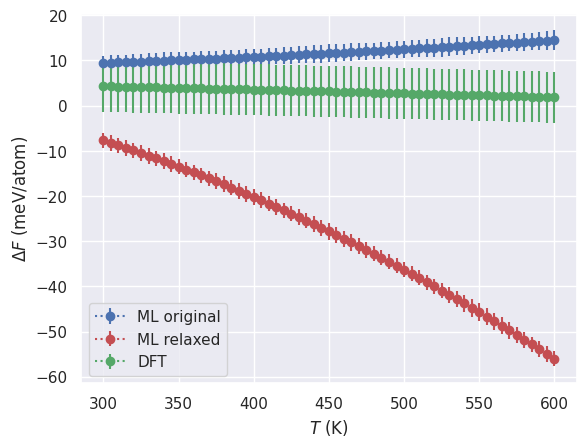

ZnCl2


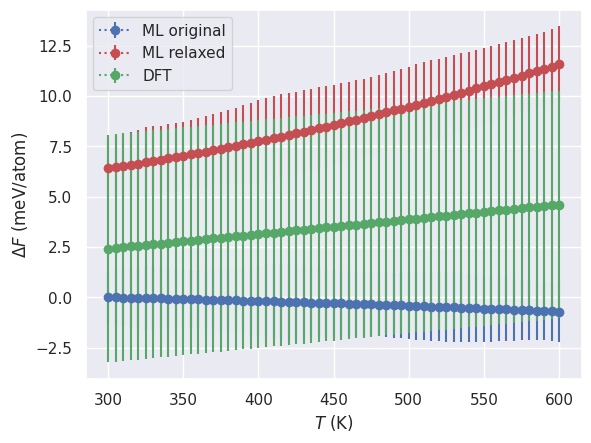

ZnTe


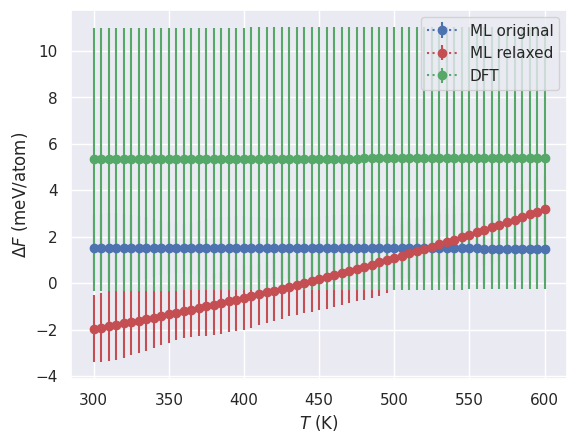

ZrSeO


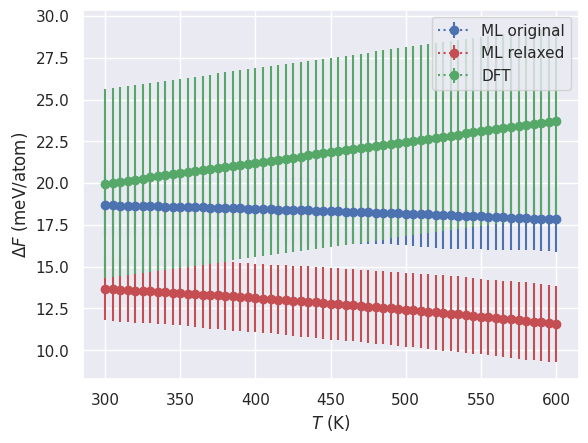

In [8]:
uncert_DFT_0 = np.ones(len(temperatures)) * 4
uncert_DFT_1 = np.ones(len(temperatures)) * 4

uplims = [False] * len(temperatures)
lolims = [False] * len(temperatures)

for material in materials.keys():
    print(material)

    polymorphs = materials[material]
    path_to_material = f'/home/claudio/Desktop/validation/{material}'

    # IDX = 0
    idx = 0
    path_to_polymorph = f'{path_to_material}/{polymorphs[idx]}'
    path_to_MP = f'{path_to_polymorph}/relaxation'
    path_to_phonons = f'{path_to_polymorph}/phonons'

    if not os.path.exists(path_to_MP):
        continue
    
    Fv_ML_MP_0, uncert_ML_MP_0 = pred_ML_Fv(path_to_MP,
                                            temperatures, standardized_parameters, model_folder, device)
    Fv_ML_phonons_0, uncert_ML_phonons_0 = pred_ML_Fv(path_to_phonons,
                                                      temperatures, standardized_parameters, model_folder, device)
    Fv_DFT_0 = pred_DFT_Fv(path_to_phonons,
                           temperatures)
    
    epa_0 = float(np.loadtxt(f'{path_to_MP}/EPA')) * 1e3  # From eV/atom to meV/atom

    
    # IDX = 1
    idx = 1
    path_to_polymorph = f'{path_to_material}/{polymorphs[idx]}'
    path_to_MP = f'{path_to_polymorph}/relaxation'
    path_to_phonons = f'{path_to_polymorph}/phonons'

    if not os.path.exists(path_to_MP):
        continue
    
    Fv_ML_MP_1, uncert_ML_MP_1 = pred_ML_Fv(path_to_MP,
                                            temperatures, standardized_parameters, model_folder, device)
    Fv_ML_phonons_1, uncert_ML_phonons_1 = pred_ML_Fv(path_to_phonons,
                                                      temperatures, standardized_parameters, model_folder, device)
    Fv_DFT_1 = pred_DFT_Fv(path_to_phonons,
                           temperatures)
    
    epa_1 = float(np.loadtxt(f'{path_to_MP}/EPA')) * 1e3  # From eV/atom to meV/atom

    
    # Diff
    F_ML_MP_diff = (epa_1+Fv_ML_MP_1) - (epa_0+Fv_ML_MP_0)
    uncert_ML_MP_diff = np.sqrt(uncert_ML_MP_0**2 + uncert_ML_MP_1**2)

    F_ML_phonons_diff = (epa_1+Fv_ML_phonons_1) - (epa_0+Fv_ML_phonons_0)
    uncert_ML_phonons_diff = np.sqrt(uncert_ML_phonons_0**2 + uncert_ML_phonons_1**2)

    F_DFT_diff = (epa_1+Fv_DFT_1) - (epa_0+Fv_DFT_0)
    uncert_DFT_diff = np.sqrt(uncert_DFT_0**2 + uncert_DFT_1**2)
    
    # Plotting
    label = f'{polymorphs[1]}-{polymorphs[0]}'
    plt.errorbar(temperatures, F_ML_MP_diff,      color=colors[0], yerr=uncert_ML_MP_diff,      label='ML original', 
                 fmt=':o', uplims=uplims, lolims=lolims)
    plt.errorbar(temperatures, F_ML_phonons_diff, color=colors[1], yerr=uncert_ML_phonons_diff, label='ML relaxed',
                 fmt=':o', uplims=uplims, lolims=lolims)
    plt.errorbar(temperatures, F_DFT_diff,        color=colors[2], yerr=uncert_DFT_diff,        label='DFT',
                 fmt=':o', uplims=uplims, lolims=lolims)
        
    plt.xlabel(r'$T$ (K)')
    plt.ylabel(r'$\Delta F$ (meV/atom)')
    plt.legend(loc='best')
    plt.savefig(f'{path_to_material}/{material}-diff.pdf', dpi=50, bbox_inches='tight')
    plt.show()

In [5]:
materials = [
    'mp-15649-20180417',
    'mp-35876-20180417',
    'mp-6179-20180417',
    'mp-989614-20180417',
    'mp-15668-20180417',
    'mp-35906-20180417',
    'mp-618177-20180417',
    'mp-989616-20180417',
    'mp-1568-20180417',
    'mp-35907-20180417'
]

mp-15649-20180417


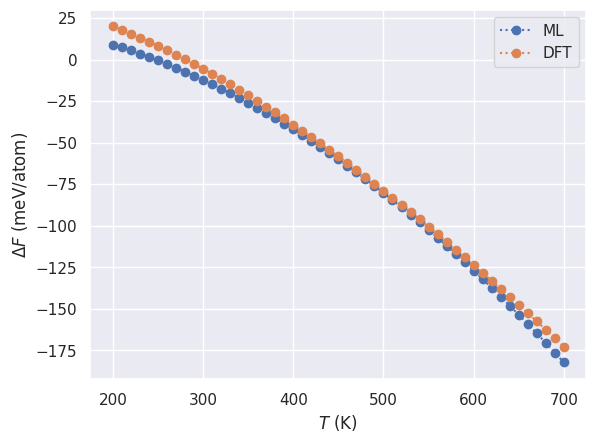

mp-35876-20180417


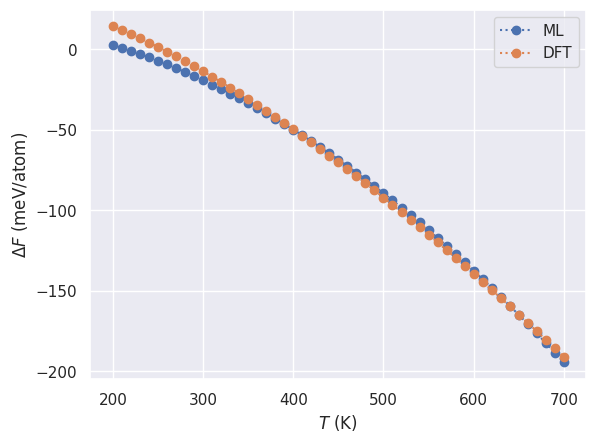

mp-6179-20180417


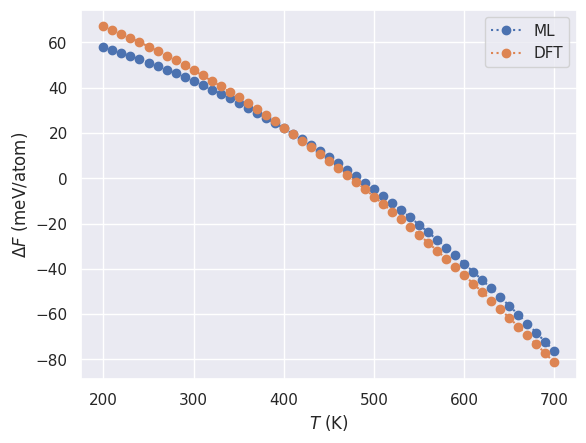

mp-989614-20180417


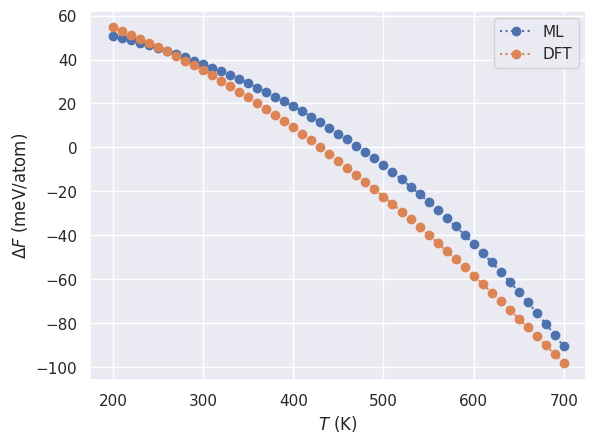

mp-15668-20180417


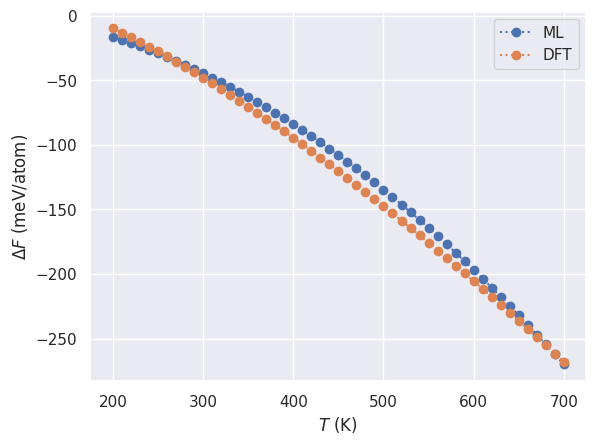

mp-35906-20180417


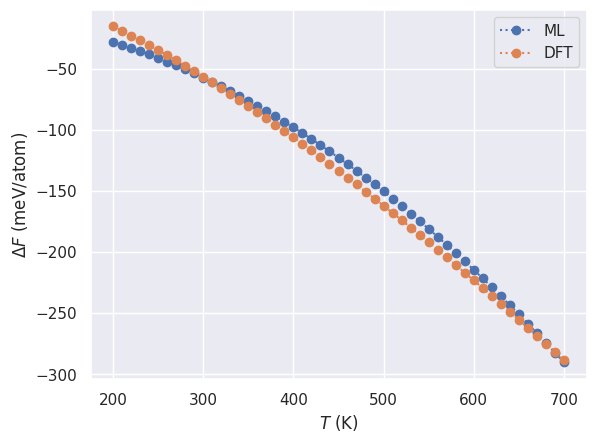

mp-618177-20180417


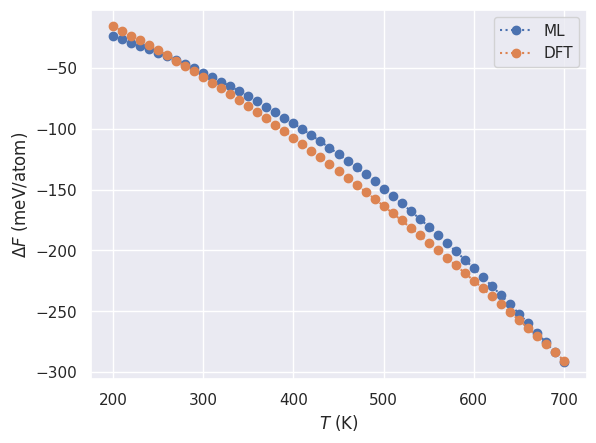

mp-989616-20180417


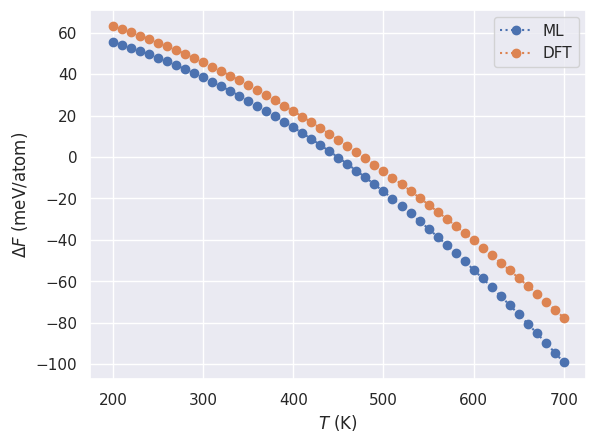

mp-1568-20180417


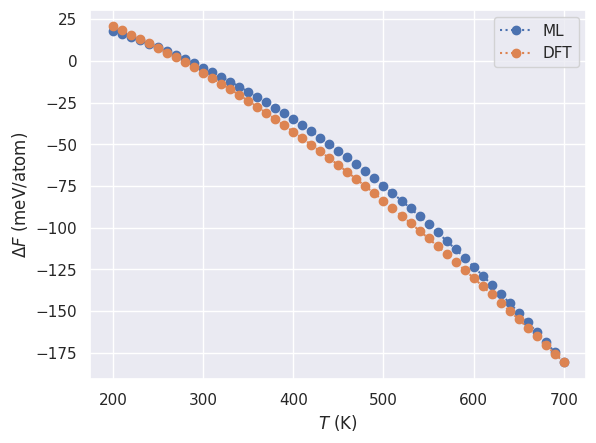

mp-35907-20180417


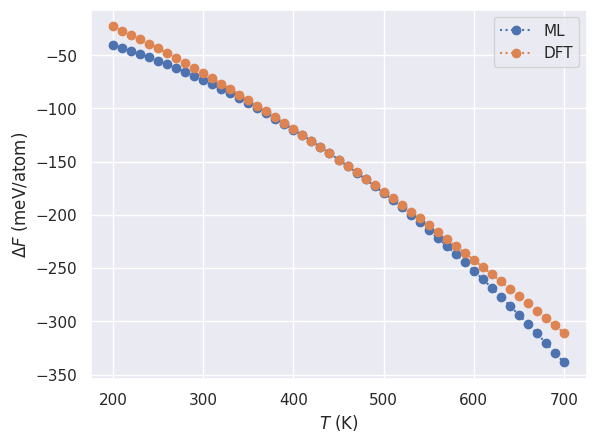

In [6]:
uncert_DFT_0 = np.ones(len(temperatures)) * 4
uncert_DFT_1 = np.ones(len(temperatures)) * 4

uplims = [False] * len(temperatures)
lolims = [False] * len(temperatures)

for material in materials:
    print(material)
    try:
        path_to_phonons = f'/home/claudio/Desktop/Loaded_real_phonons/{material}'
        
        Fv_ML_MP_0, uncert_ML_MP_0 = pred_ML_Fv(path_to_phonons,
                                                temperatures, standardized_parameters, model_folder, device)
        Fv_DFT_0 = pred_DFT_Fv(path_to_phonons,
                               temperatures)
        
        # Plotting
        plt.plot(temperatures, Fv_ML_MP_0, ':o', label='ML')
        plt.plot(temperatures, Fv_DFT_0,   ':o', label='DFT')
            
        plt.xlabel(r'$T$ (K)')
        plt.ylabel(r'$\Delta F$ (meV/atom)')
        plt.legend(loc='best')
        plt.show()
    except:
        pass

mp-15649-20180417


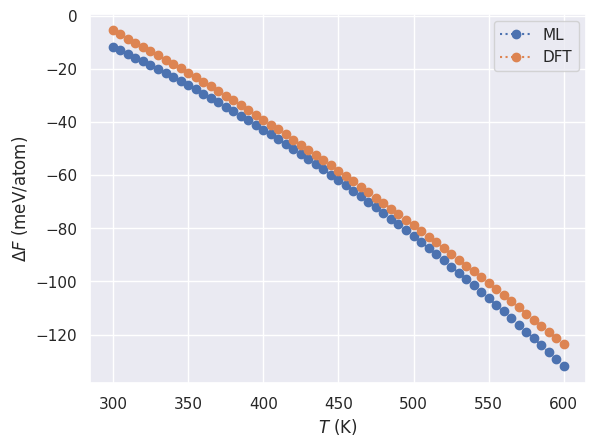

mp-35876-20180417


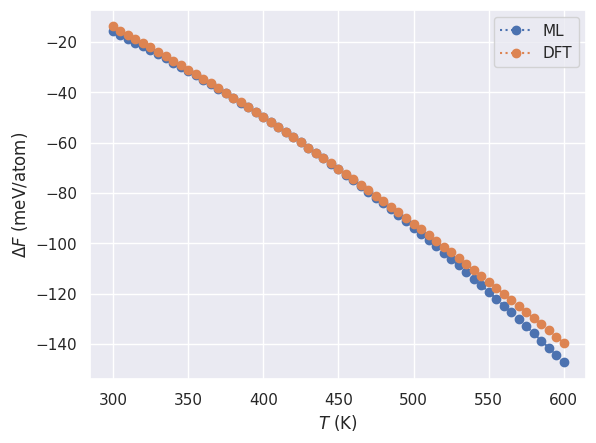

mp-6179-20180417


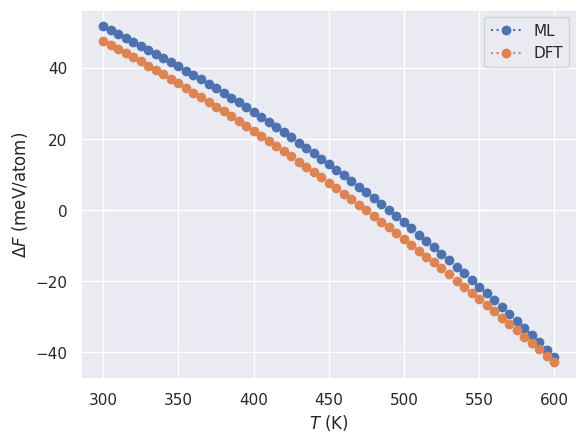

mp-989614-20180417


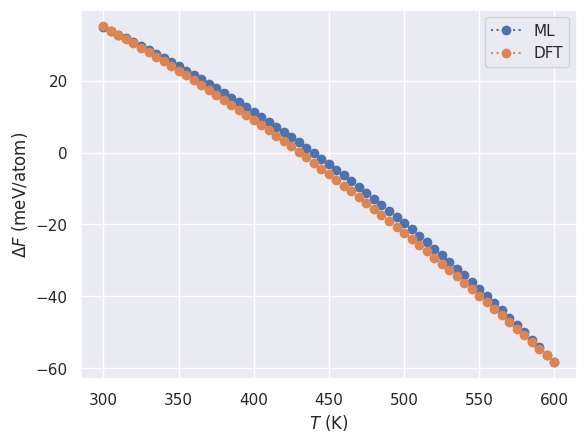

mp-15668-20180417


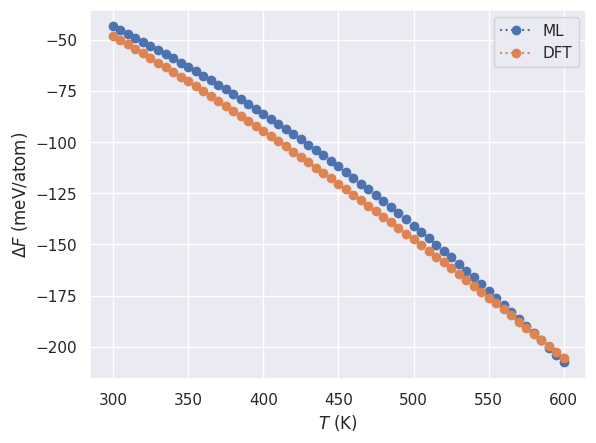

mp-35906-20180417


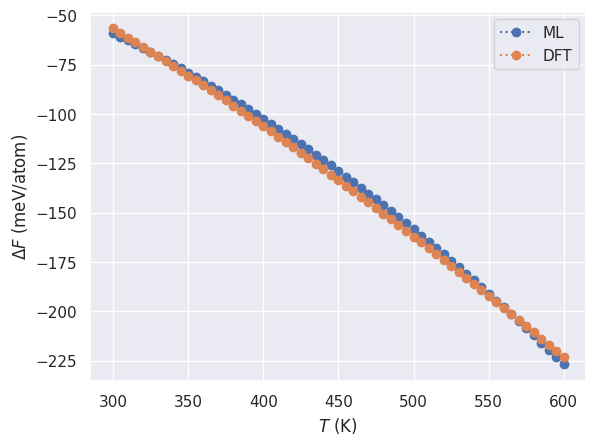

mp-618177-20180417


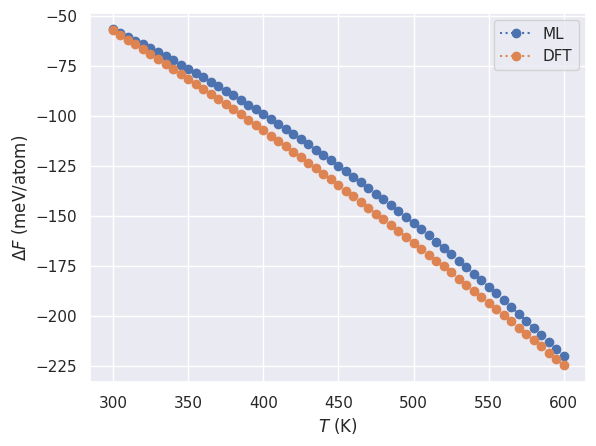

mp-989616-20180417


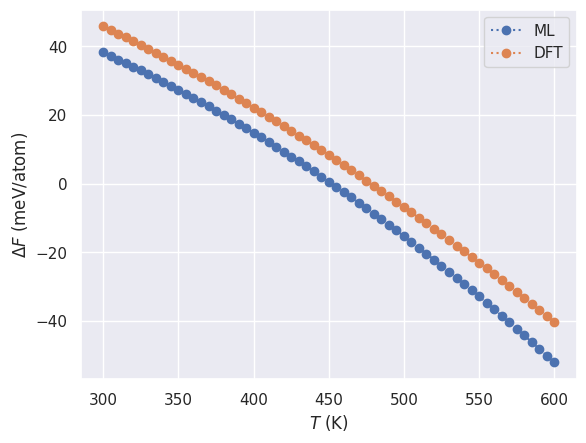

mp-1568-20180417


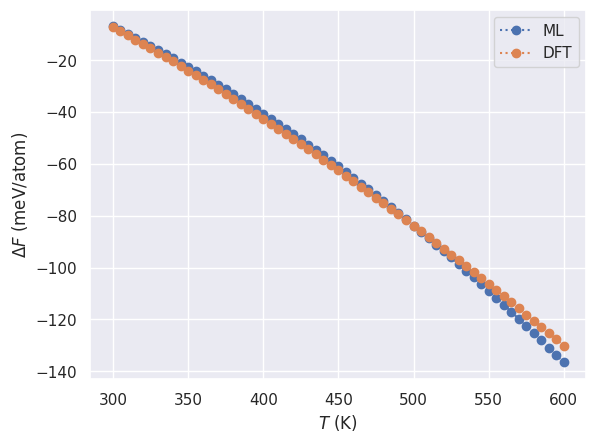

mp-35907-20180417


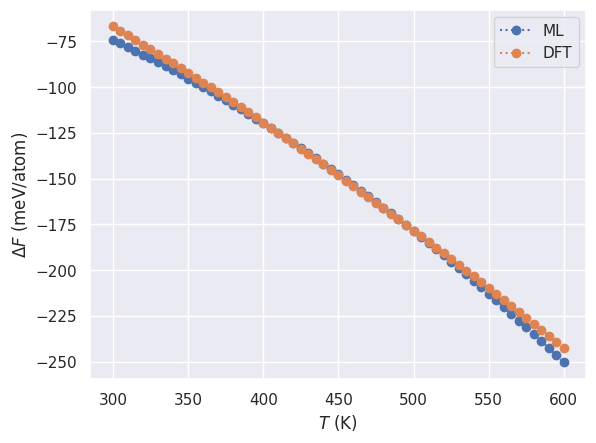

In [7]:
materials = {
    'BaCl2': {
        'I4-mmm',
        'BaCl2/P-62m'
    },
    'CaBH42': {
        'Fddd',
        'I-42d'
    },
    'Li2FeCoO4': {
        'C2-c',
        'R-3m'
    },
    'MgS': {
        'F-43m',
        'Fm-3m',
        'P6_3-mmc'
    },
    'NaHO': {
        'P4-nmm',
        'R3m'
    },
    'RbAgSe': {
        'Cmcm',
        'P4-nmm',
        'P6_3-mmc',
        'P6_3-mmc_2'
    },
    'RbScO2': {
        'P6_3-mmc',
        'R-3m'
    },
    'BH6N': {
        'Cmc2_1',
        'Pmn2_1'
    },
    'CsYO2': {
        'P6_3-mmc',
        'R-3m',
        'R-3m_2'
    },
    'MgF2': {
        'P2_1-c',
        'P-3m1',
        'Pnnm',
        'R-3m'
    },
    'NaH': {
        'Fm-3m',
        'Pm-3m'
    },
    'NaZnP': {
        'P4-nmm',
        'P6_3-mmc',
        'P6_3-mmc_2'
    },
    'RbCuTe': {
        'P6_3-mmc',
        'P6_3-mmc_2
    }
}

In [5]:
materials = {
    'MgS': {
        'F-43m',
        'Fm-3m',
        'P6_3-mmc'
    },
    'MgF2': {
        'P-3m1',
        'Pnnm'
    },
    'NaH': {
        'Fm-3m',
        'Pm-3m'
    }
}

MgS


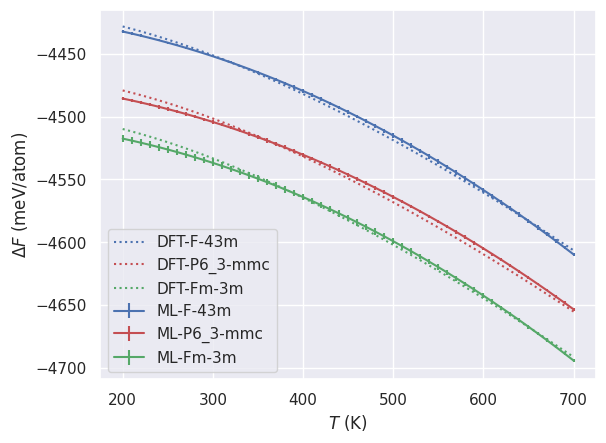

MgF2


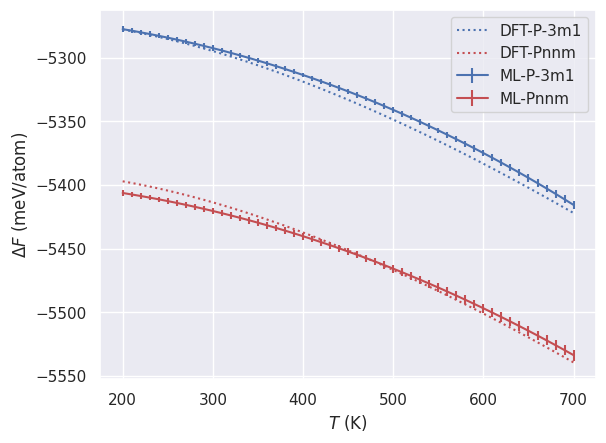

NaH


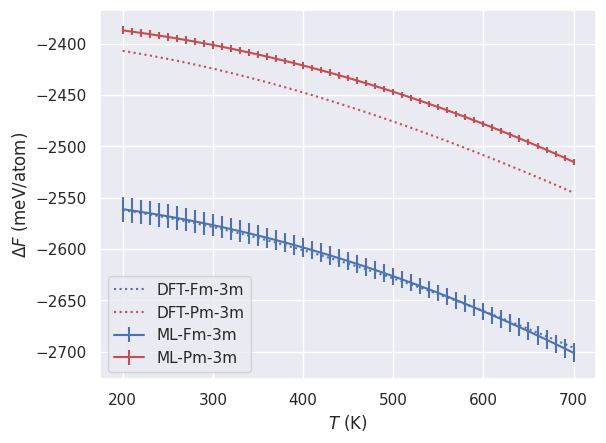

In [6]:
colors = ['b', 'r', 'g', 'k']
for material in materials.keys():
    print(material)
    try:
        for i, polymorph in enumerate(materials[material]):
            path_to_phonons = f'/home/claudio/Desktop/cibran-varios/Fv-things/validation-phonons/{material}/{polymorph}'
            
            Fv_ML, uncert_ML = pred_ML_Fv(path_to_phonons,
                                          temperatures, standardized_parameters, model_folder, device)
            Fv_DFT = pred_DFT_Fv(path_to_phonons,
                                 temperatures)
            
            # Plotting
            epa = np.loadtxt(f'{path_to_phonons}/EPA') * 1e3
            space_group = np.loadtxt(f'{path_to_phonons}/EPA')
            plt.errorbar(temperatures, epa+Fv_ML, yerr=uncert_ML, ls='-', color=colors[i], label=f'ML-{polymorph}')
            plt.plot(temperatures, epa+Fv_DFT, ':', color=colors[i], label=f'DFT-{polymorph}')
            
        plt.xlabel(r'$T$ (K)')
        plt.ylabel(r'$\Delta F$ (meV/atom)')
        plt.legend(loc='best')
        plt.show()
    except:
        pass